In [41]:
# If running in Google Colab, mount drive
print('Check if running in Colab...')
try:
    from google.colab import drive
    print('Running in Colab!')
    drive.mount('/content/drive')
    %cd '/content/drive/My Drive/CIL-FS20'
except ImportError:
    print('Running locally!')

    #Check python version
    from platform import python_version
    print('Current python version: {}'.format(python_version()))

    # Check available GPUs
    import tensorflow as tf
    no_GPUs_available = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Number of GPUs Available: {}".format(no_GPUs_available))

Check if running in Colab...
Running locally!
Current python version: 3.6.10
Number of GPUs Available: 0


In [42]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from keras import backend as K
import keras
import random
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from datetime import datetime

from mask_to_submission import masks_to_submission
import util

In [43]:
## Install the following packages
import imageio
from PIL import Image
import cv2
import natsort

## Constants

In [44]:
IMG_WIDTH = 608
IMG_HEIGHT = 608
PATCH_HEIGHT = 160
PATCH_WIDTH = 160
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

# Set random seeds for reproducibility
rnd_seed = 4
np.random.seed(rnd_seed)

## Load Images

In [45]:
training_images_dir = "training_images/images/"
training_labels_dir = "training_images/groundtruth/"
test_images_dir = "test_images/"

# Lad filenames
files_images = os.listdir(training_images_dir)
files_images = natsort.natsorted(files_images)
files_labels = os.listdir(training_labels_dir)
files_labels = natsort.natsorted(files_labels)
files_test = os.listdir(test_images_dir)
files_test = natsort.natsorted(files_test)
n = len(files_images)
n_test = len(files_test) 

# Load list of numpy arrays of training images and labels
print("Loading " + str(n) + " training images")
training_images_list = []
training_labels_list = []
for i in range(n):
    print("Loading training image {:04d}\r".format(i)),
    training_images_list.append(imageio.imread(training_images_dir + files_images[i]))
    training_labels_list.append(imageio.imread(training_labels_dir + files_labels[i]))

# Load list of numpy arrays of test images
print("Loading " + str(n_test) + " test images")
test_images_list = [imageio.imread(test_images_dir + files_test[i]) for i in range(n_test)]

# Convert lists to numpy arrays
training_images = np.array(training_images_list)
training_labels = np.expand_dims(np.array(training_labels_list), -1)
test_images = np.array(test_images_list)

print("TRAINING:")
print(training_images.shape)
print(training_labels.shape)
print("TEST:")
print(test_images.shape)

Loading 100 training images
Loading training image 0000
Loading training image 0001
Loading training image 0002
Loading training image 0003
Loading training image 0004
Loading training image 0005
Loading training image 0006
Loading training image 0007
Loading training image 0008
Loading training image 0009
Loading training image 0010
Loading training image 0011
Loading training image 0012
Loading training image 0013
Loading training image 0014
Loading training image 0015
Loading training image 0016
Loading training image 0017
Loading training image 0018
Loading training image 0019
Loading training image 0020
Loading training image 0021
Loading training image 0022
Loading training image 0023
Loading training image 0024
Loading training image 0025
Loading training image 0026
Loading training image 0027
Loading training image 0028
Loading training image 0029
Loading training image 0030
Loading training image 0031
Loading training image 0032
Loading training image 0033
Loading training ima

## Preprocess Images
1. Randomize Training Images and take some of the training data as validation set
2. Split up Training Images into patches of size 160x160 (need to be divisible by 32!)
3. Split up Test Images into patches of size 152x152
4. Padd Test Images into size 160x160

In [46]:
# Get a validation set
training_images, validation_images, training_labels, validation_labels = train_test_split(
    training_images, training_labels, test_size=0.1, random_state=rnd_seed)

# Image patchifying and padding
validation_images = util.patchify(validation_images, 160, 160, 80)
validation_labels = util.patchify(validation_labels, 160, 160, 80)
training_images = util.patchify(training_images, 160, 160, 80)
training_labels = util.patchify(training_labels, 160, 160, 80)
test_images = util.patchify(test_images, 152, 152, 152)
test_images = util.padd_images(test_images, 4)

print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)
print(test_images.shape)

(1440, 160, 160, 3)
(1440, 160, 160, 1)
(160, 160, 160, 3)
(160, 160, 160, 1)
(1504, 160, 160, 3)


In [47]:
# Make sure label masks only have values 1 or zero
thresh_val = 0.5
training_labels = (training_labels > thresh_val).astype(np.uint8)
print(np.unique(training_labels, return_counts=True, axis=None))

(array([0, 1], dtype=uint8), array([28517088,  8346912], dtype=int64))


## Augment Training Data

Each training image can be rotated by 90 degrees and vertically an horizontally flipped. 
By doing so we increase our training data by a factor of 16.

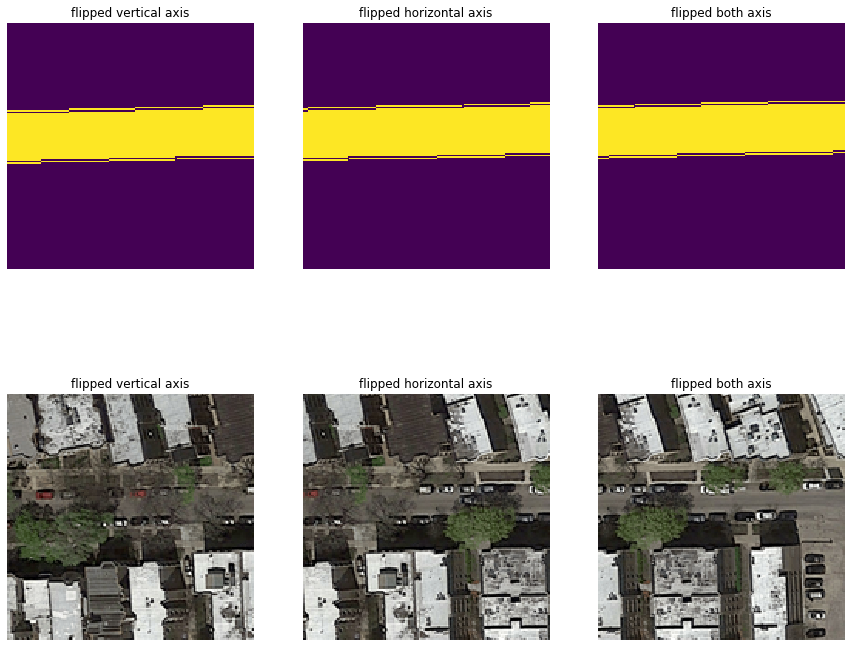

Amount of training samples: 23040
(23040, 160, 160, 3)
(23040, 160, 160, 1)


In [23]:
# flip training images horizontally, vertically and on both axes to increase training data *4
training_images = util.add_flipped_images(training_images)
training_images = util.add_rotated_images(training_images)
training_labels = util.add_flipped_images(training_labels)
training_labels = util.add_rotated_images(training_labels)

n = training_images.shape[0]
training_labels = np.squeeze(training_labels)

# Plot flipped images
f = plt.figure(figsize = (15, 25))

f.add_subplot(1, 3, 1)
plt.imshow(training_images[0])
plt.title("flipped vertical axis")
plt.axis('off')

f.add_subplot(1, 3, 2)
plt.imshow(training_images[1])
plt.title("flipped horizontal axis")
plt.axis('off')

f.add_subplot(1, 3, 3)
plt.imshow(training_images[2])
plt.title("flipped both axis")
plt.axis('off')

f.add_subplot(2, 3, 1)
plt.imshow(training_labels[0])
plt.title("flipped vertical axis")
plt.axis('off')

f.add_subplot(2, 3, 2)
plt.imshow(training_labels[1])
plt.title("flipped horizontal axis")
plt.axis('off')

f.add_subplot(2, 3, 3)
plt.imshow(training_labels[2])
plt.title("flipped both axis")
plt.axis('off')
plt.show()

training_labels = np.expand_dims(training_labels, -1)

print("Amount of training samples: " + str(n))
print(training_images.shape)
print(training_labels.shape)

## Loss Function and Accuracy Metric
- Accuracy: Intersection of prediction to label image over Union
- Loss :
    - Jaccard Distance (Current Best for patches)
    - Dice Coef Loss (https://arxiv.org/pdf/1606.04797v1.pdf)
    - Soft Dice Loss (Measure of interleaving of prediction image and label image)

Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99

In [48]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def soft_dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-soft_dice_coef(y_true, y_pred)

## Model: Fully CNN built in Keras

In [49]:
inputs = Input((PATCH_HEIGHT, PATCH_WIDTH, 3))

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 160, 160, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 160, 160, 16) 64          conv2d_58[0][0]                  
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 160, 160, 16) 0           batch_normalization_55[0][0]     
____________________________________________________________________________________________

## Callbacks for Observations

In [50]:
#tbc=TensorBoardColab()
model_path = "./Models/fullyCNN_patches_temp.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
csv_logger = CSVLogger("./Logs/fullyCNN_patches_log.csv", separator=',', append=False)
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=6,
                               verbose=1,
                               epsilon=1e-4)

## Model Training

In [51]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=jaccard_distance,
      metrics=[iou_coef])

In [52]:
# Labels are allready 1 or 0 now!
history = model.fit(training_images,
                    training_labels,
                    validation_data =(validation_images, validation_labels),
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, csv_logger, lr_reducer]
                    )

Train on 1296 samples, validate on 144 samples
Epoch 1/100
1296/1296 [==============================] - 545s 421ms/step - loss: 0.3983 - iou_coef: 0.2600 - val_loss: 0.6434 - val_iou_coef: 0.2400

Epoch 00001: val_loss improved from inf to 0.64340, saving model to ./Models/fullyCNN_patches_temp.h5
Epoch 2/100
  16/1296 [..............................] - ETA: 8:12 - loss: 0.3009 - iou_coef: 0.3430

KeyboardInterrupt: 

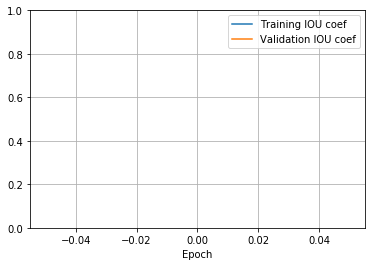

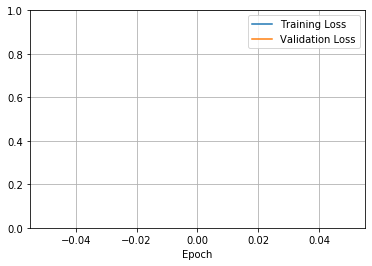

In [53]:
# Show a training report
training_info = pd.read_csv('./Logs/fullyCNN_patches_log.csv', header=0)

acc1, = plt.plot(training_info['epoch'], training_info['iou_coef'])
acc2, = plt.plot(training_info['epoch'], training_info['val_iou_coef'])
plt.legend([acc1, acc2], ['Training IOU coef', 'Validation IOU coef'])
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)
plt.show()

loss1, = plt.plot(training_info['epoch'], training_info['loss'])
loss2, = plt.plot(training_info['epoch'], training_info['val_loss'])
plt.legend([acc1, acc2], ['Training Loss', 'Validation Loss'])                            
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)

plt.show()

## Model Evaluation

In [58]:
model = load_model("./Models/fullyCNN_patches_temp.h5", custom_objects={'jaccard_distance': jaccard_distance, 'iou_coef': iou_coef})
#model.evaluate(test_images, test_label)
predictions = model.predict(test_images, verbose=1)

1504/1504 [==============================] - 201s 134ms/step


In [59]:
predictions = util.crop_images(predictions, 4)
predictions = util.unpatchify(predictions, 152, 152, 608, 608, 0)
test_images = util.crop_images(test_images, 4)
test_images = util.unpatchify(test_images, 152, 152, 608, 608, 0)

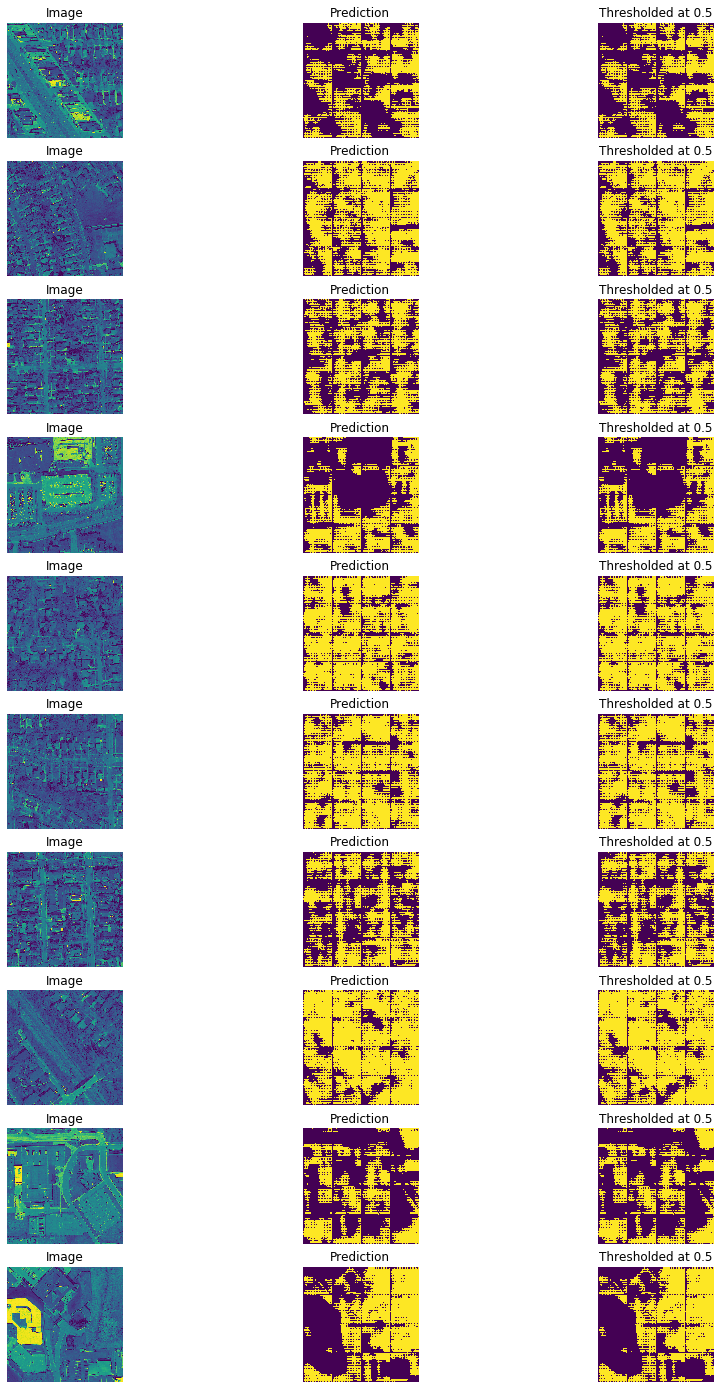

In [61]:
thresh_val = 0.5
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

index = random.randint(0, len(predictions)-1)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*3, 3):
  index = random.randint(0, len(predictions)-1)

  f.add_subplot(num_samples, 3, i)
  plt.imshow(test_images[index][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  plt.imshow(np.squeeze(predictions[index][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  plt.imshow(np.squeeze(predicton_threshold[index][:,:,0]))
  plt.title("Thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()

## Create Submission File

In [ ]:
result_dir = './Results/Prediction_Images/'
[imageio.imwrite(result_dir + files_test[i], predictions[i]) for i in range(n_test)]
files_predictions = os.listdir(result_dir)
files_predictions = [result_dir + files_predictions[i] for i in range(n_test)]
masks_to_submission('./Results/Submissions/fullyCNN_patches_19_April.csv', *files_predictions)
print('Submission ready')